# Buckley Leverett 

## Purpose
The purpose of this notebook is to set-up the solution for the Buckley Leverett equation.

## Equation

The following equation needs to be solved:
$$
\dfrac{A \phi}{q}\dfrac{\partial S_w}{\partial t} + \dfrac{\partial f_w}{\partial S_w}\dfrac{\partial S_w}{\partial x} =0
$$
with the boundary an initial conditions:
$$
\begin{cases}
S_w(x,0) = S_{wi}\\
S_w(0,t) =S_{winj}\\
\end{cases}
$$
with $t \geq 0$ and $ 0 \leq x \leq L$.

The fractional flow of water, $f_w$, is given by:
$$
f_w(S_w) = \dfrac{q_w}{q} = 
           \left. \dfrac{k_{rw}}{\mu_w} \middle/ \left( \dfrac{k_{rw}}{\mu_w} + 
                  \dfrac{k_{ro}}{\mu_o}\right) \right. 
           \left\{ 1- \dfrac{k k_{ro} A}{q \mu_o} \Delta \rho \sin\alpha \right\}
$$
with $ \Delta\rho = \rho_w - \rho_o$.

In the above equations $S_w$ is the water saturation, $q$ is the total volumetric fluid rate, $\phi$ the porosity and $A$ the area open to flow. 
Moreover, $k_{rw}$ and $k_{ro}$ are the water resp. oil relative permeabilities, $\mu_w$ and $\mu_{o}$ the water resp. oil viscosities and $\rho_w$ and $\rho_o$ are the water resp. oil densities.. It is assumed that the relative permeabilities are only dependent on $S_w$. The absolute permeability is denoted by $k$ and the dip angle by $\alpha$ (the angle is measured wrt the horizontal plane and the positive direction is anti-clockwise). Finally, $S_{winj}$ is the water saturation corresponding to pure water injection, i.e. $f_w = 1$ at $x=0$, $S_{wi}$ is the initial water saturation in the 'reservoir'.

The following dimensionless variables are introduced:
$$
\begin{align}
x_D &= \frac{x}{L}\\
t_D &= \frac{u}{\phi L}t = \frac{Q_{inj}}{V_p} \\
\end{align}
$$ 
With the above the equation becomes:
$$
\dfrac{\partial S_w}{\partial t_D} + \dfrac{\partial f_w}{\partial S_w}\dfrac{\partial S_w}{\partial x_D} =0
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.integrate import odeint

import buckley_leverett_util as blu

# Input parameters

## Parametrization

The following parametrization ias used for the relperm parameters: 
$$
\begin{align}
k_{rw}(S_w) & = k^e_{rw} S^{n_w} \\
k_{ro}(S_w) & = k^e_{ro} (1-S)^{n_o}
\end{align}
$$

where
$$
S = \frac{(S_w-S_{cw})}{(1-S_{cw}-S_{orw})}
$$
## Conditions on the parameters
For the relative permeabilities we require:
$$
k^e_{rw}, k^e_{ro} > 0 \\
n_w, n_o \geq 1 \\
0 < S_{cw} < 1-S_{orw}< 1 \\
$$
The solution in this code has only been tested for Corey exponents in the above range, not investigated what happens for smaller exponents.

## Some more useful dimensionless numbers

Endpoint mobility ratio:
$$M = \frac{k^e_{rw}}{\mu_w} / \frac{\mu_o}{k^e_{ro}}$$

Dimensionless gravity number:
$$
N_G = \dfrac{k k^e_{ro} A}{q \mu_o} \Delta \rho \sin\alpha

$$
Note that we have absorbed the term $\sin\alpha$ in $N_G$. In the literature this is not always done.

With the above the fractional flow has the following form:
$$f_w(S_w) = \frac{MS^{nw}}{(1-S)^{no}+MS^{nw}} \Big( 1-N_{G}(1-S)^{no})\Big)$$
again with
$$
S = \frac{(S_w-S_{cw})}{(1-S_{cw}-S_{orw})}
$$

In [2]:
# The viscosities are input in cP.
params = { 'krwe': 1.0, 'nw': 2., 'Scw': 0.1,
           'kroe': 1.0, 'no': 2, 'Sorw': 0.1,
           'muo': 2, 'muw': 1.0}

# The absolute permeability is input in mD.
# The water and oil densities, rhow and rhoo, are input in kg/m^3.
# The total flow rate, qtot, is input in m^3/day.
# The cross-sectional area, area, is input in m^2.
# The dip angle, dip, is input in degrees. It is measured wrt the horizontal plane
# and the positive direction is anti-clockwise
grav_params = {'kabs': 1000, 'kroe': params['kroe'], 'muo': params['muo'],
               'rhow': 1000, 'rhoo': 800, 'qtot': 10, 'area': 1000, 'dip':-20}

# Calculate the dimensionless gravity number, NG
NG = blu.calc_NG(params_dict = grav_params)
print(f'Dimensionless gravity number incl. dip effect = {NG:6.4e}')
print(f'Dimensionless gravity number excl. dip effect = {NG/np.sin(grav_params['dip']*np.pi/180):4.2e}')

# Gravity is included for GravOn=True, otherwise it is not included.
bl = blu.BuckleyLeverett(params_dict = params, GravOn=False, NG=NG)

Dimensionless gravity number incl. dip effect = -2.8609e+00
Dimensionless gravity number excl. dip effect = 8.36e+00
__init__: Swinj = 9.00000000e-01
BL_events: Sw1 = 5.61880215e-01, events = rare + shock


# Description of the general solution

Depending on the input parameters the solution takes one of the following three forms:
1) shock wave from $S_{winj}$ to $S_{wi}$
2) rarefaction wave from $S_{winj}$ to $S_{wi}$
3) rarefaction wave from $S_{winj}$ to $S_{w1}$ followed by a shock from $S_{w1}$ to $S_{wi}$ where $S_{w1}$ can be found be solving the Rankine-Hugoniot condition:
$$
\dfrac{\partial f_w}{\partial S_w}\left(S_{w1}\right) = \frac{f_w(S_{w1})-f_w(S_{wi})}{S_{w1}-S_{wi}}
$$
The last form is the traditional Welge solution to the Buckley Leverett equation.

Sw1 = 0.5619
Mobility ratio             = 2.00e+00
Shock front mobility ratio = 8.45e-01
rarefaction speed, front = shock speed = 1.71e+00
Breakthrough after 5.86e-01 PV injected


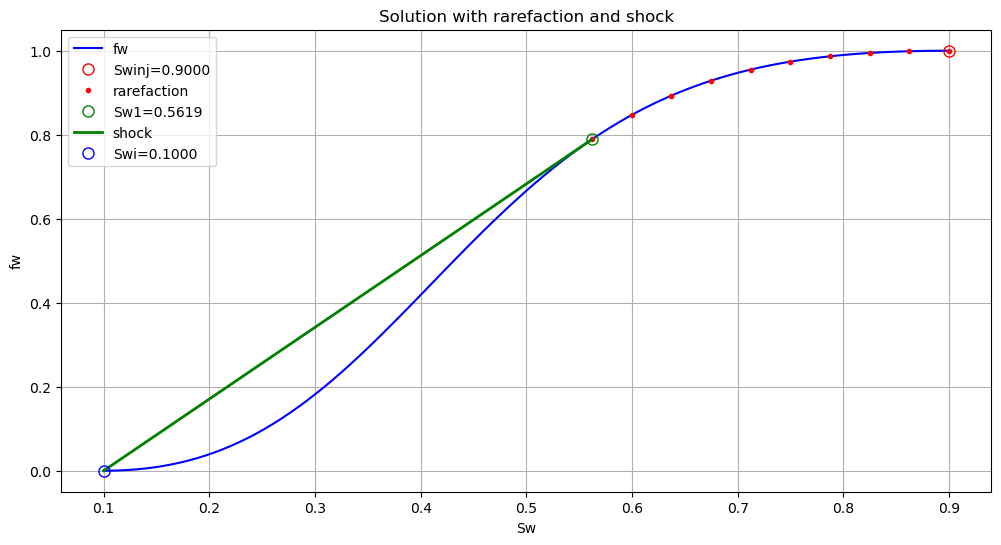

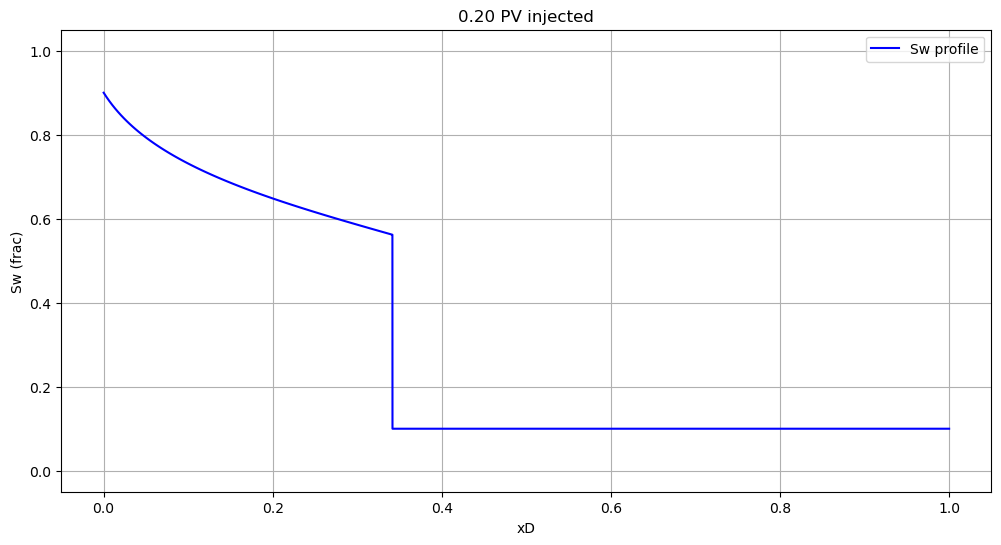

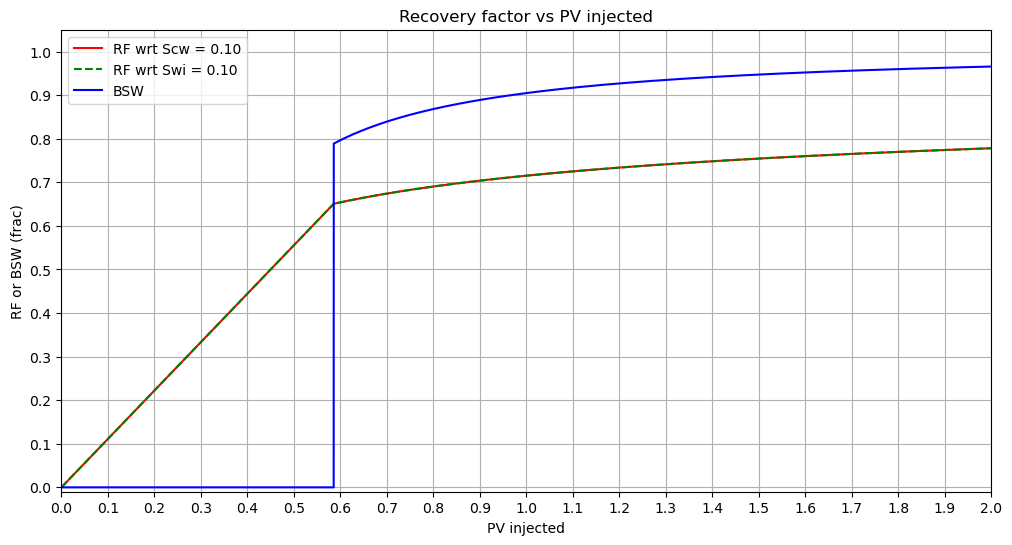

In [3]:
fig, ax = bl.plot_solution()
ax.set_title('Solution with rarefaction and shock')
data, fig_prf, ax_prf = bl.plot_profile(0.2,sizex=12, sizey=6) 
RF_Scw, RF_Swi, BSW, fig_RF, ax_RF = bl.plot_RF()
fig_RF.set_figheight(6)
fig_RF.set_figwidth(12)
ax_RF.set_xlim(0,2)
ax_RF.set_xticks(np.arange(0,2.05,0.1)); # This semicolon suppresses output from this command


Mobility ratio = 2.00e+00
rarefaction speed, front = 2.50e+00
Breakthrough after 4.00e-01 PV injected


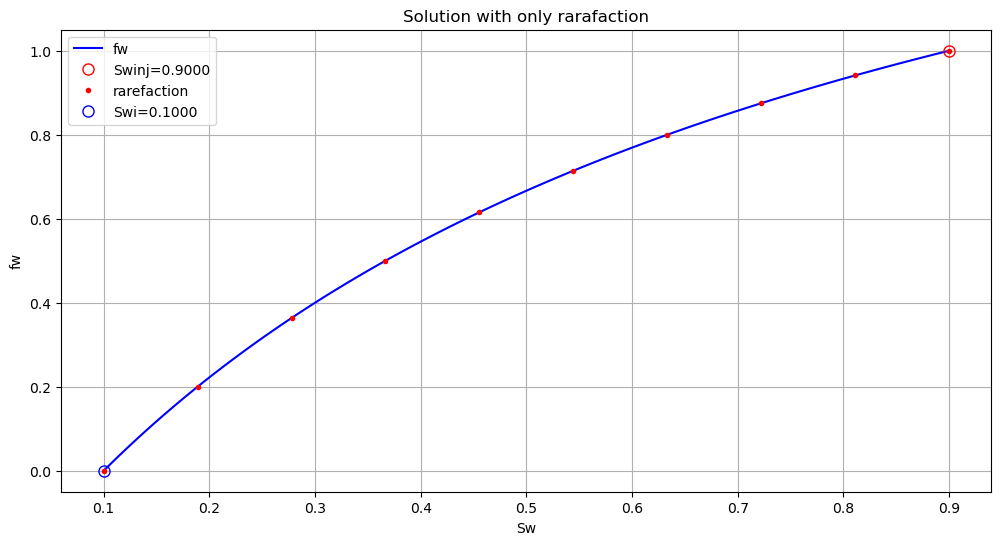

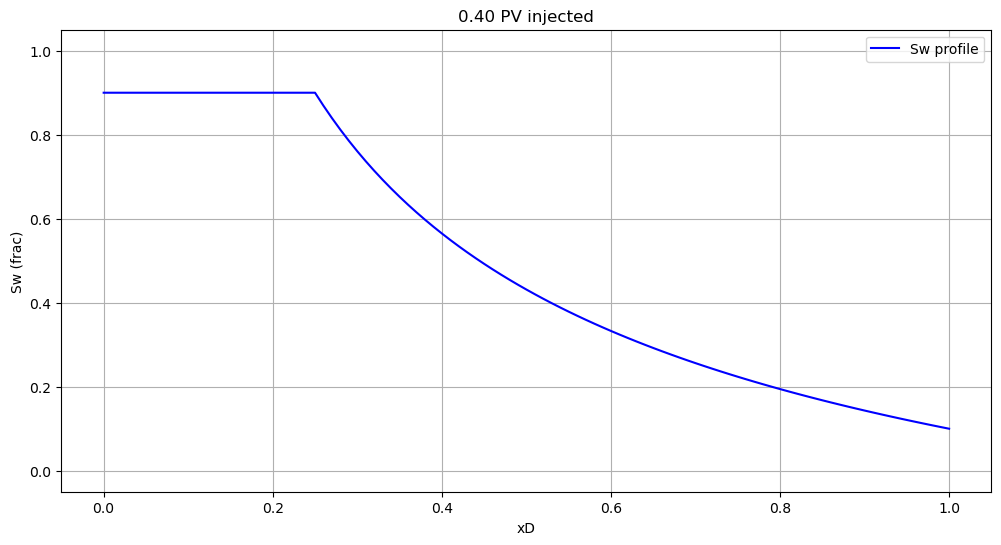

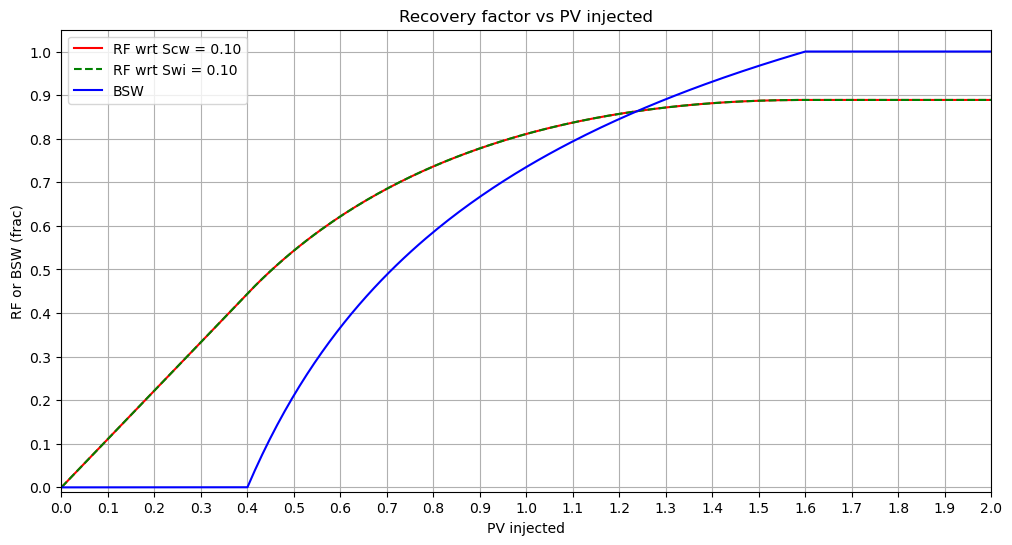

In [4]:
# The viscosities are input in cP.
params_rare = { 'krwe': 1.0, 'nw': 1., 'Scw': 0.1,
                'kroe': 1.0, 'no': 1, 'Sorw': 0.1,
                'muo': 2, 'muw': 1.0}
bl_rare = blu.BuckleyLeverett(params_dict = params_rare)
fig, ax = bl_rare.plot_solution()
ax.set_title('Solution with only rarafaction')
data, fig_prf, ax_prf = bl_rare.plot_profile(0.4,sizex=12, sizey=6) 
RF_Scw, RF_Swi, BSW, fig_RF, ax_RF = bl_rare.plot_RF()
fig_RF.set_figheight(6)
fig_RF.set_figwidth(12)
ax_RF.set_xlim(0,2)
ax_RF.set_xticks(np.arange(0,2.05,0.1)); # This semicolon suppresses output from this command

Mobility ratio             = 5.00e-01
Shock front mobility ratio = 5.00e-01
shock speed = 1.25
Breakthrough after 8.00e-01 PV injected


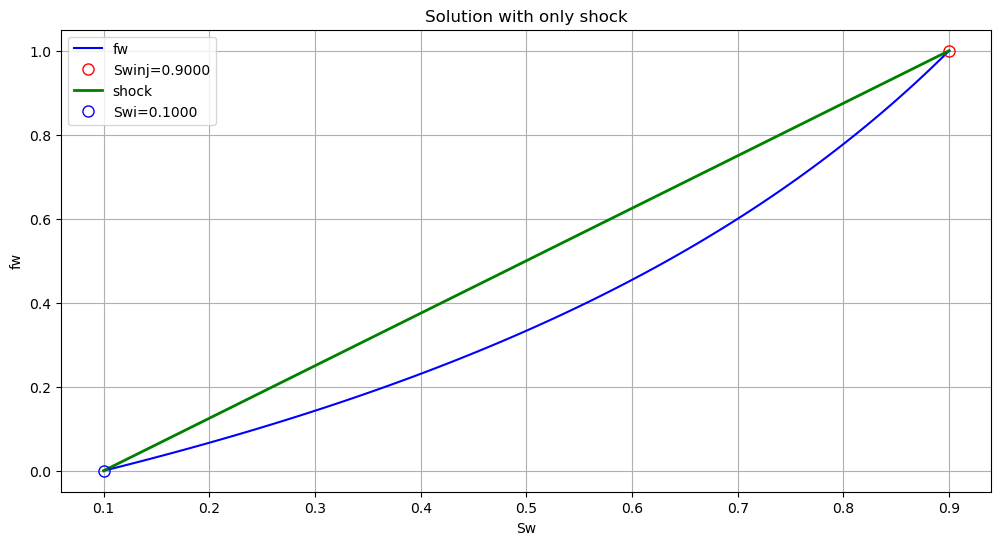

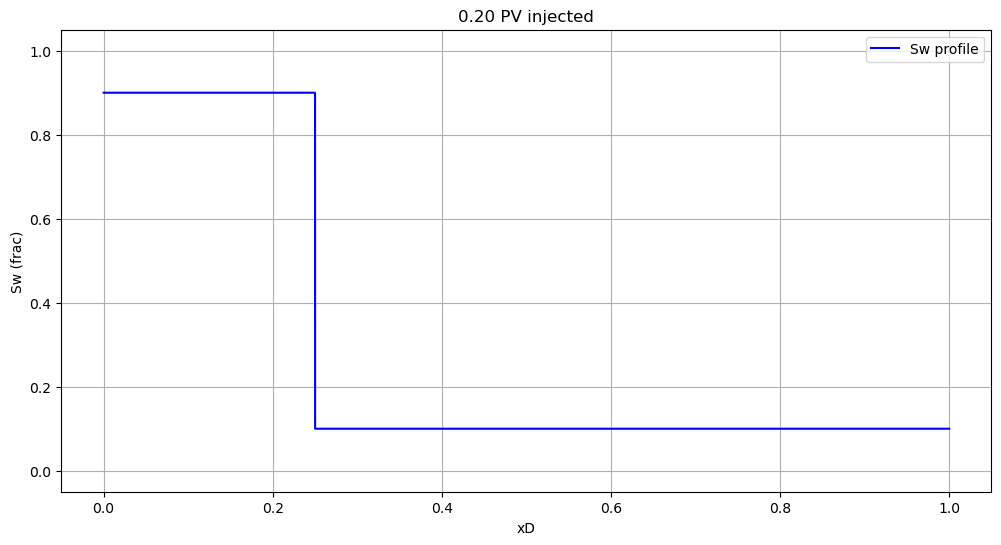

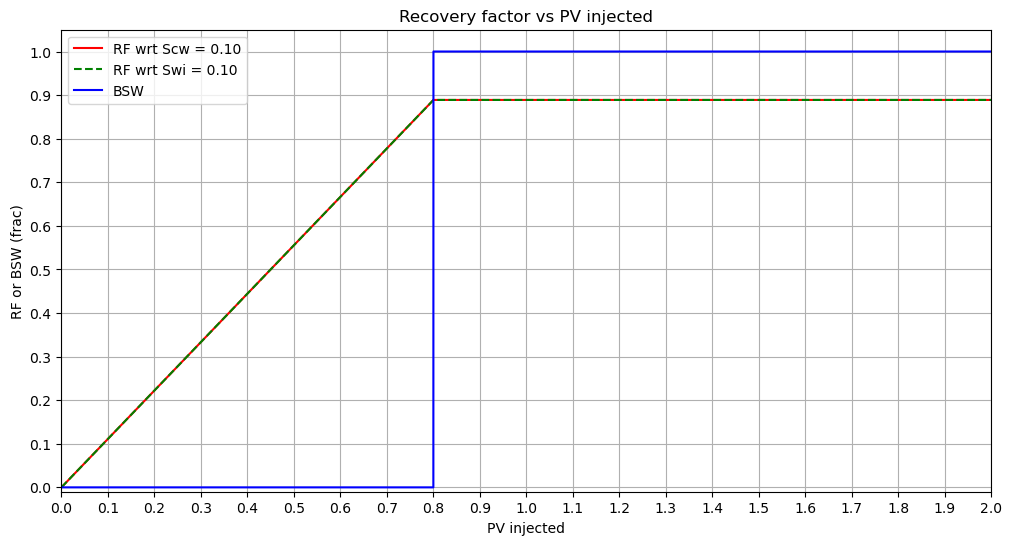

In [5]:
# The viscosities are input in cP.
params_shock = { 'krwe': 1.0, 'nw': 1., 'Scw': 0.1,
                 'kroe': 1.0, 'no': 1, 'Sorw': 0.1,
                 'muo': 0.5, 'muw': 1.0}
bl_shock = blu.BuckleyLeverett(params_dict = params_shock)
fig, ax = bl_shock.plot_solution()
ax.set_title('Solution with only shock')
data, fig_prf, ax_prf = bl_shock.plot_profile(0.2,sizex=12, sizey=6) 
RF_Scw, RF_Swi, BSW, fig_RF, ax_RF = bl_shock.plot_RF()
fig_RF.set_figheight(6)
fig_RF.set_figwidth(12)
ax_RF.set_xlim(0,2)
ax_RF.set_xticks(np.arange(0,2.05,0.1)); # This semicolon suppresses output from this command

# Welge construction is equivalent to the Convex Hull approach

In the mathematical literature the so called convex hull approach is discussed. The idea is to construct a convex hull of the set $\left\{(S_w,y): S_{wr} \leq S_w \leq S_{wl} \text{  and  } y \leq f_w{S_w} \right\}$. Parts of the hull that overlap the fractional flow curve correspond to rarefactions, other parts of the hull correspond to shocks.

This has also been implemented in the code and is demonstrated below.

In [6]:
# The viscosities are input in cP.
params = { 'krwe': 1.0, 'nw': 2., 'Scw': 0.1,
           'kroe': 1.0, 'no': 3, 'Sorw': 0.1,
           'muo': 4, 'muw': 1.0}

# The absolute permeability is input in mD.
# The water and oil densities, rhow and rhoo, are input in kg/m^3.
# The total flow rate, qtot, is input in m^3/day.
# The cross-sectional area, area, is input in m^2.
# The dip angle, dip, is input in degrees. It is measured wrt the horizontal plane
# and the positive direction is anti-clockwise
grav_params = {'kabs': 1000, 'kroe': params['kroe'], 'muo': params['muo'],
               'rhow': 1000, 'rhoo': 800, 'qtot': 10, 'area': 1000, 'dip':10}

# Calculate the dimensionless gravity number, NG
NG = blu.calc_NG(params_dict = grav_params)
print(f'Dimensionless gravity number incl. dip effect = {NG:6.4e}')
print(f'Dimensionless gravity number excl. dip effect = {NG/np.sin(grav_params['dip']*np.pi/180):4.2e}')

# Gravity is included for GravOn=True, otherwise it is not included.
bl_hull = blu.BuckleyLeverett(params_dict = params, GravOn=True, NG=NG)

Dimensionless gravity number incl. dip effect = 7.2627e-01
Dimensionless gravity number excl. dip effect = 4.18e+00
__init__: Swinj = 9.00000000e-01
BL_events: Sw_lo = 1.00000010e-01, Error from brentq:  f(a) and f(b) must have different signs
BL_events: Sw1 = 4.75110281e-01, events = rare + shock


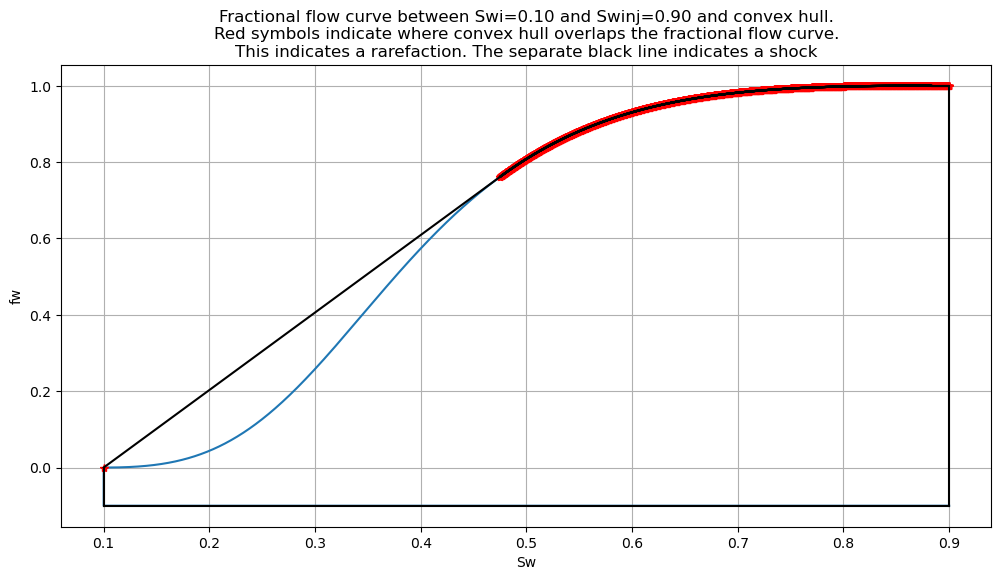

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(bl_hull.box.T[0],bl_hull.box.T[1])
ax.plot(bl_hull.box[bl_hull.vertices,0], bl_hull.box[bl_hull.vertices,1], 'r*', lw=2)
for simplex in bl_hull.hull.simplices:
    ax.plot(bl_hull.box[simplex, 0], bl_hull.box[simplex, 1], 'k-')
ax.set_title(f'Fractional flow curve between Swi={bl_hull.Swi:4.2f} and Swinj={bl_hull.Swinj:4.2f} and convex hull.\n'
          f'Red symbols indicate where convex hull overlaps the fractional flow curve.\n'
          f'This indicates a rarefaction. The separate black line indicates a shock')
ax.set_ylabel('fw')
ax.set_xlabel('Sw')
ax.grid()

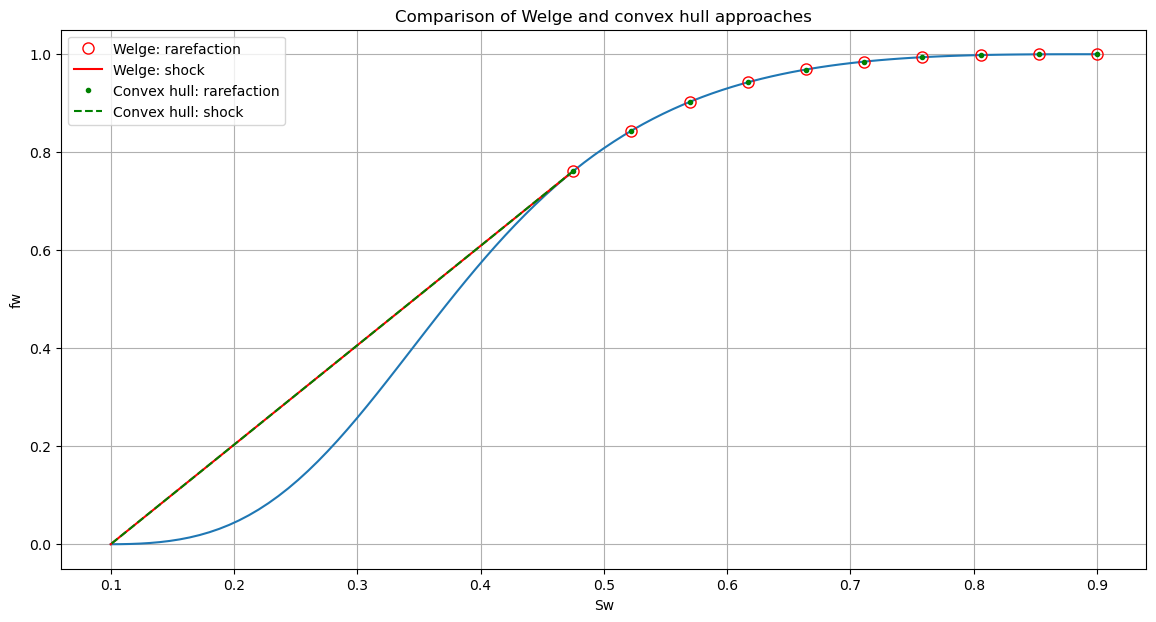

In [8]:
fig, ax = plt.subplots(figsize=(14,7))

Ss = np.linspace(bl_hull.Scw, 1-bl_hull.Sorw, 101)

ax.plot(Ss, bl_hull.fw(Ss))
if bl_hull.events =='shock':
    ax.plot((bl_hull.Sw1,bl_hull.Swinj),(bl_hull.fw(bl_hull.Sw1),bl_hull.fw(bl_hull.Swinj)),'r-', label='Welge: shock')
elif bl_hull.events == 'rare':
    Srare = np.linspace(bl_hull.Sw1,bl_hull.Swinj,10)
    ax.plot(Srare,bl_hull.fw(Srare),'ro', markersize=8, fillstyle='none', label='Welge: rarefaction')
else:
    Srare = np.linspace(bl_hull.Sw1,bl_hull.Swinj,10)
    ax.plot(Srare,bl_hull.fw(Srare),'ro', markersize=8, fillstyle='none', label='Welge: rarefaction')
    ax.plot((bl_hull.Swi,bl_hull.Sw1),(bl_hull.fw(bl_hull.Swi),bl_hull.fw(bl_hull.Sw1)),'r-', label='Welge: shock')

for v in bl_hull.events_hull.values():
    if v[0] == 's':
        ax.plot((v[1],v[2]),(bl_hull.fw(v[1]),bl_hull.fw(v[2])),'g--', label='Convex hull: shock')
    else:
        Srare = np.linspace(v[1],v[2],10)
        ax.plot(Srare,bl_hull.fw(Srare),'g.', label='Convex hull: rarefaction')
ax.set_title('Comparison of Welge and convex hull approaches')
ax.set_xlabel('Sw')
ax.set_ylabel('fw')
ax.legend()
ax.grid()

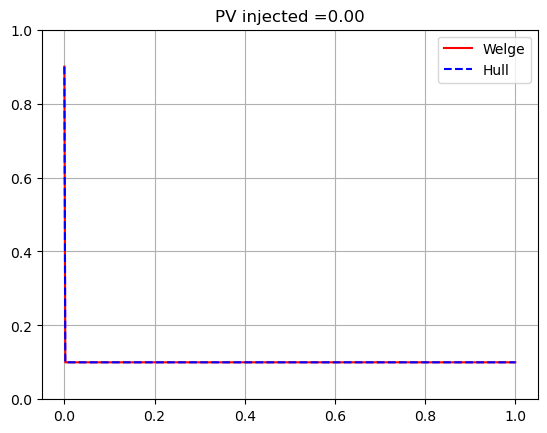

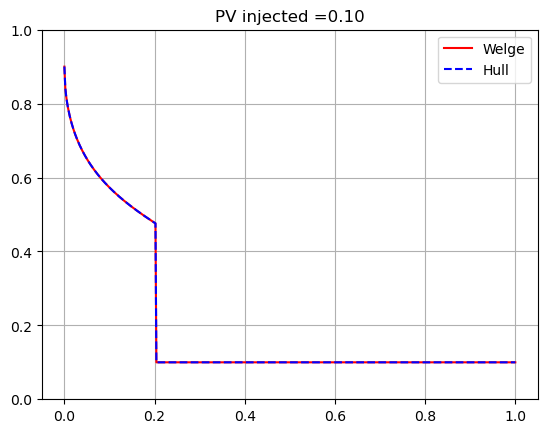

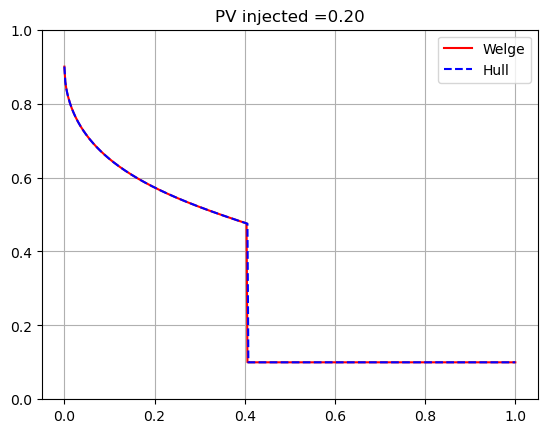

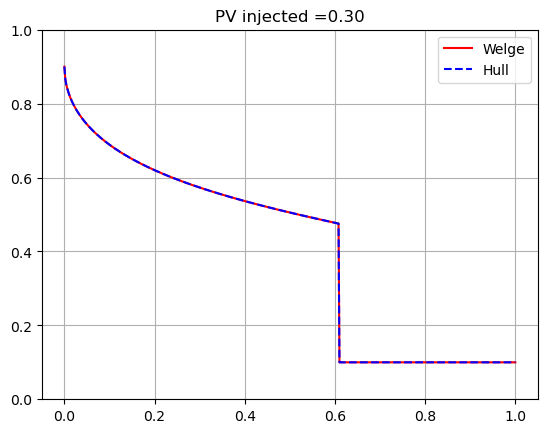

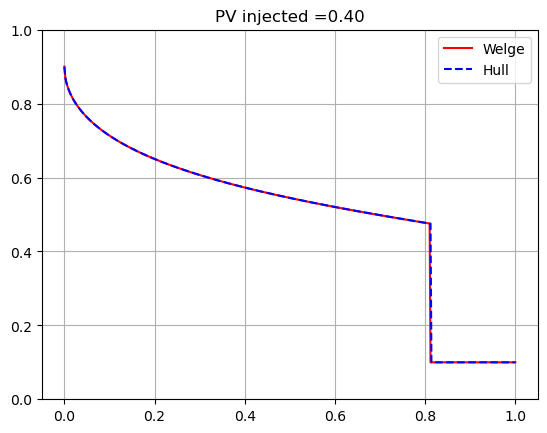

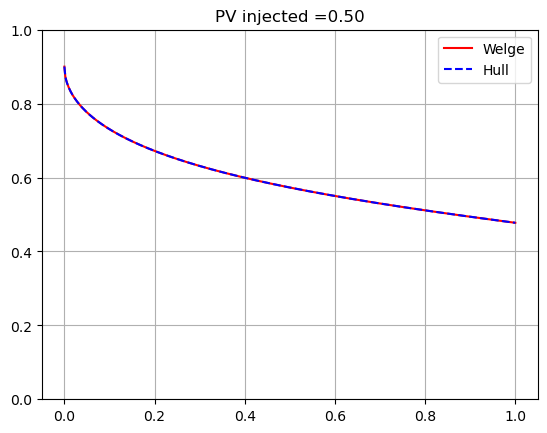

In [9]:
ts = np.linspace(0, 0.5, 6)
xs = np.linspace(0, 1, 501)
for t in ts:
    data = pd.Series()
    data_hull = pd.Series()
    for x in xs:
        data[x] = bl_hull.calc_Sol(x,t)
        data_hull[x] =bl_hull.calc_Sol_hull(x,t)
        plt.title(f'PV injected ={t:4.2f}')
    plt.plot(data, 'r-', label='Welge')
    plt.plot(data_hull, 'b--', label='Hull')
    plt.legend()
    plt.ylim(0,1)
    plt.grid()
    plt.show()

# Gravity effects

When gravity is included the fractional flow curve is no longer monotonically increasing with Sw.
If the dip angle is positive the fractional flow curve can go negative; if it is negative the fractional flow curve can become large than one. These are indications of cross flow going on.

If the dip is negative and the fractional flow curve becomes larger than one, the injection saturation, Swinj,  cannot be set to 1-Sorw. If this is done the solution will involve a second shock from Swinj with a negative velocity; this is not valid as we are trying to impose a positive injection rate. In such cases the code selects the lowest Sw saturation at which fw=1 and sets that as the injection saturation Swinj.

## Gravity effects: positive dip

In [10]:
# The viscosities are input in cP.
params = { 'krwe': 1.0, 'nw': 2., 'Scw': 0.1,
           'kroe': 1.0, 'no': 3, 'Sorw': 0.1,
           'muo': 2, 'muw': 1.0}

# The absolute permeability is input in mD.
# The water and oil densities, rhow and rhoo, are input in kg/m^3.
# The total flow rate, qtot, is input in m^3/day.
# The cross-sectional area, area, is input in m^2.
# The dip angle, dip, is input in degrees. It is measured wrt the horizontal plane
# and the positive direction is anti-clockwise
grav_params = {'kabs': 1000, 'kroe': params['kroe'], 'muo': params['muo'],
               'rhow': 1000, 'rhoo': 800, 'qtot': 10, 'area': 1000, 'dip':20}

# Calculate the dimensionless gravity number, NG
NG = blu.calc_NG(params_dict = grav_params)
print(f'Dimensionless gravity number incl. dip effect = {NG:6.4e}')
print(f'Dimensionless gravity number excl. dip effect = {NG/np.sin(grav_params['dip']*np.pi/180):4.2e}')

# Gravity is included for GravOn=True, otherwise it is not included.
bl_dip_pos = blu.BuckleyLeverett(params_dict = params, GravOn=True, NG=NG)

Dimensionless gravity number incl. dip effect = 2.8609e+00
Dimensionless gravity number excl. dip effect = 8.36e+00
__init__: Swinj = 9.00000000e-01
BL_events: Sw_lo = 2.60343919e-01
BL_events: Sw1 = 6.37164056e-01, events = rare + shock


Sw1 = 0.6372
Mobility ratio             = 2.00e+00
Shock front mobility ratio = 9.37e-01
rarefaction speed, front = shock speed = 1.61e+00
Breakthrough after 6.21e-01 PV injected


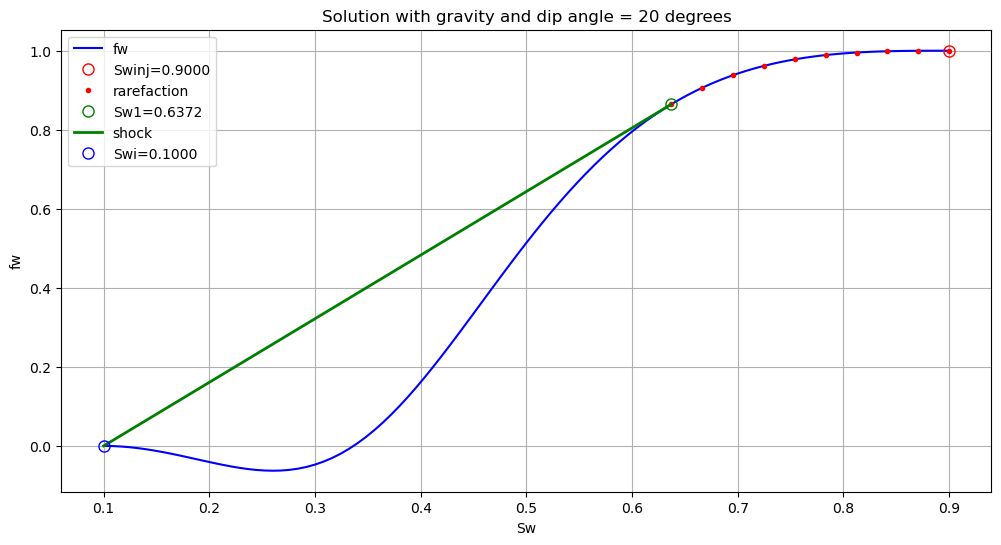

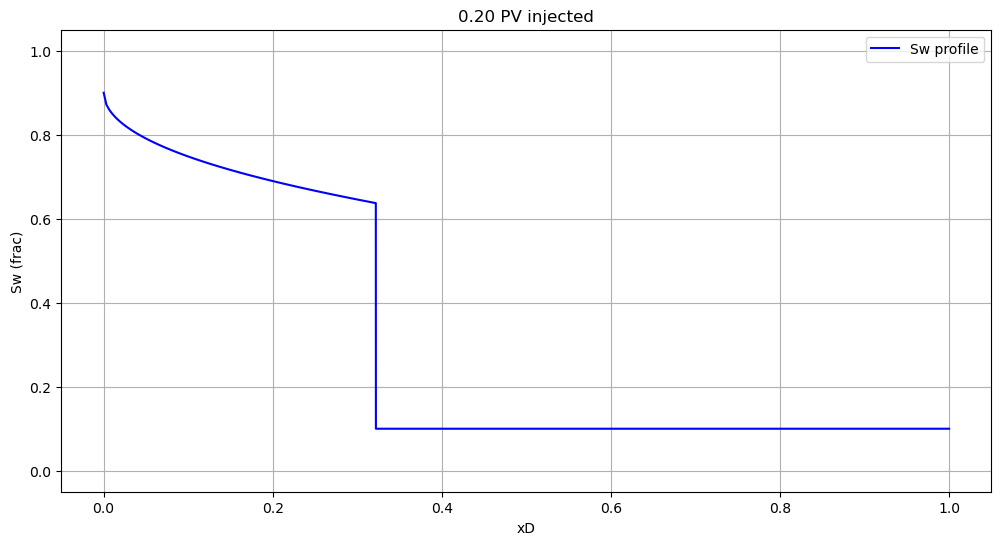

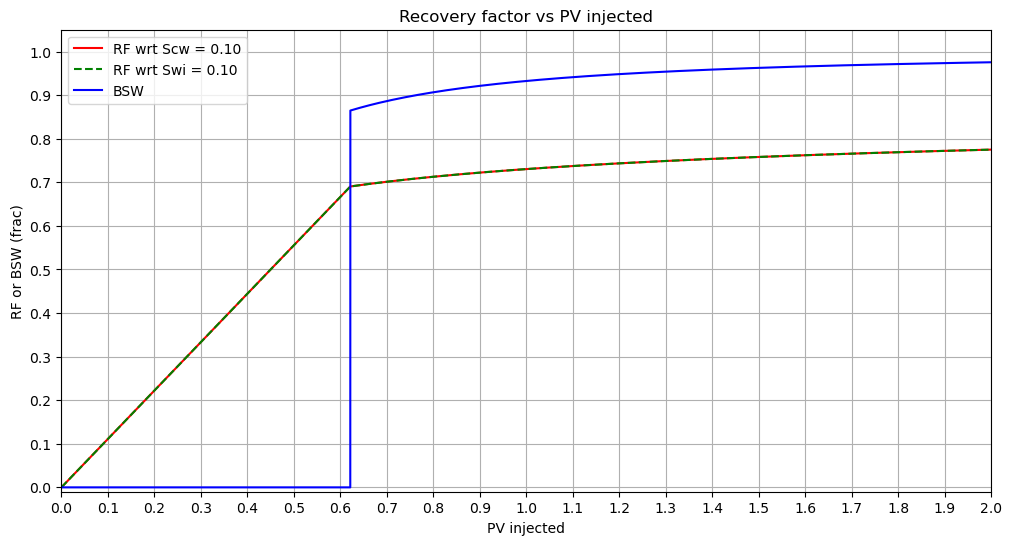

In [11]:
fig, ax = bl_dip_pos.plot_solution()
ax.set_title(f'Solution with gravity and dip angle = {grav_params['dip']:d} degrees')
data, fig_prf, ax_prf = bl_dip_pos.plot_profile(0.2,sizex=12, sizey=6) 
RF_Scw, RF_Swi, BSW, fig_RF, ax_RF = bl_dip_pos.plot_RF()
fig_RF.set_figheight(6)
fig_RF.set_figwidth(12)
ax_RF.set_xlim(0,2)
ax_RF.set_xticks(np.arange(0,2.05,0.1)); # This semicolon suppresses output from this command

## Gravity effects: negative dip

Note that the code moves Swinj to a value lower than 1-Sorw

In [12]:
# The viscosities are input in cP.
params = { 'krwe': 1.0, 'nw': 2., 'Scw': 0.1,
           'kroe': 1.0, 'no': 3, 'Sorw': 0.1,
           'muo': 2, 'muw': 1.0}

# The absolute permeability is input in mD.
# The water and oil densities, rhow and rhoo, are input in kg/m^3.
# The total flow rate, qtot, is input in m^3/day.
# The cross-sectional area, area, is input in m^2.
# The dip angle, dip, is input in degrees. It is measured wrt the horizontal plane
# and the positive direction is anti-clockwise
grav_params = {'kabs': 1000, 'kroe': params['kroe'], 'muo': params['muo'],
               'rhow': 1000, 'rhoo': 800, 'qtot': 10, 'area': 1000, 'dip':-20}

# Calculate the dimensionless gravity number, NG
NG = blu.calc_NG(params_dict = grav_params)
print(f'Dimensionless gravity number incl. dip effect = {NG:6.4e}')
print(f'Dimensionless gravity number excl. dip effect = {NG/np.sin(grav_params['dip']*np.pi/180):4.2e}')

# Gravity is included for GravOn=True, otherwise it is not included.
bl_dip_neg = blu.BuckleyLeverett(params_dict = params, GravOn=True, NG=NG)

Dimensionless gravity number incl. dip effect = -2.8609e+00
Dimensionless gravity number excl. dip effect = 8.36e+00
__init__: Swinj = 4.34442329e-01
BL_events: Sw1 = 4.02888239e-01, events = rare + shock


Sw1 = 0.4029
Mobility ratio             = 2.00e+00
Shock front mobility ratio = 5.27e-01
rarefaction speed, front = shock speed = 3.03e+00
Breakthrough after 3.30e-01 PV injected


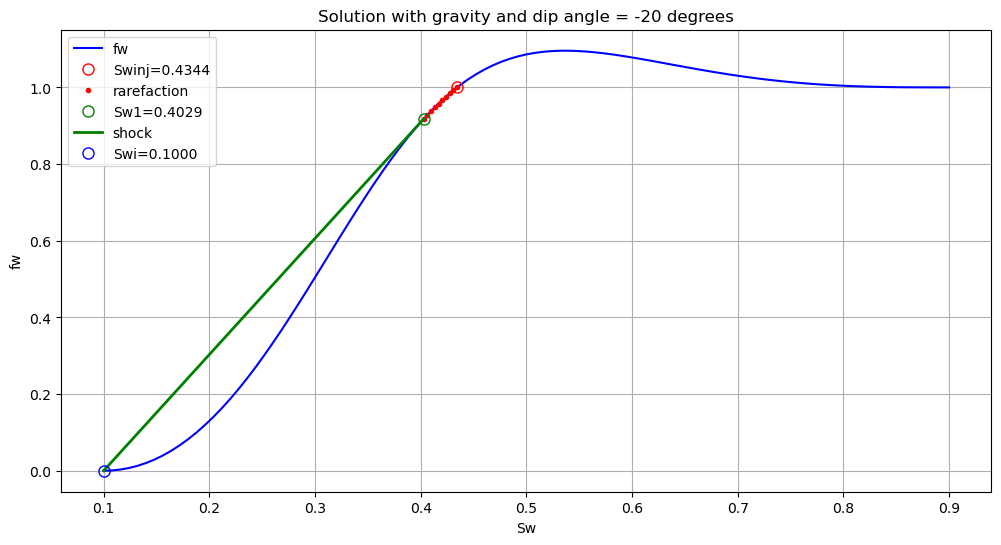

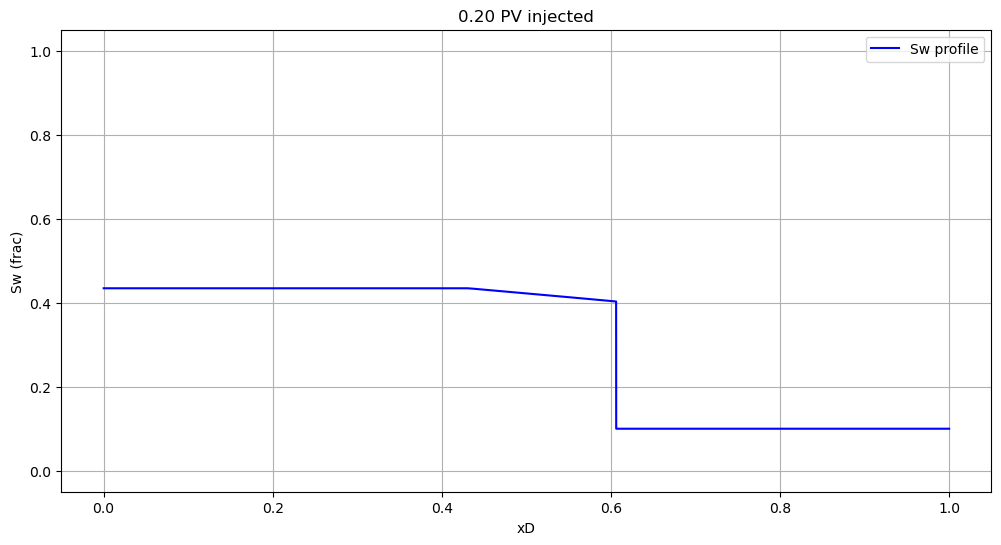

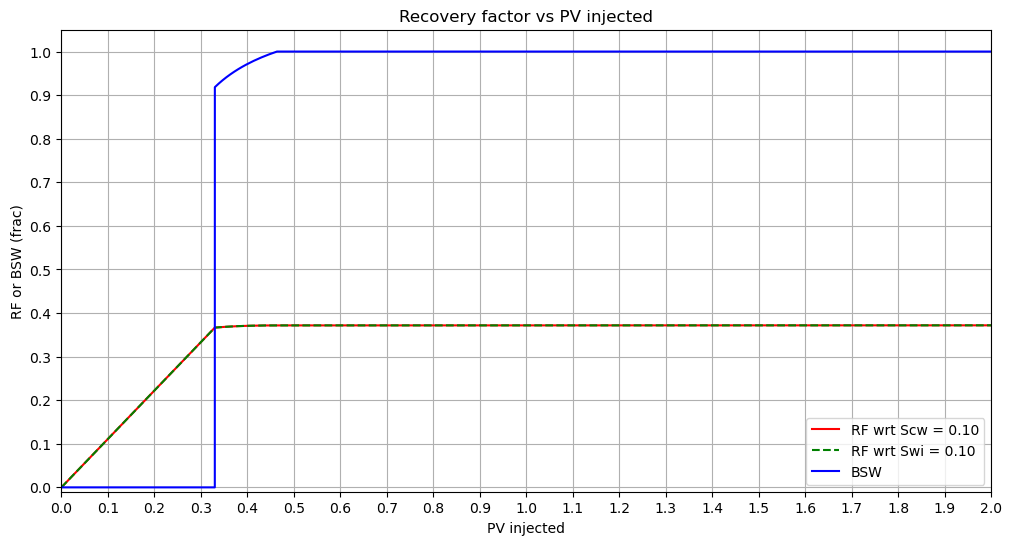

In [13]:
fig, ax = bl_dip_neg.plot_solution()
ax.set_title(f'Solution with gravity and dip angle = {grav_params['dip']:d} degrees')
data, fig_prf, ax_prf = bl_dip_neg.plot_profile(0.2,sizex=12, sizey=6) 
RF_Scw, RF_Swi, BSW, fig_RF, ax_RF = bl_dip_neg.plot_RF()
fig_RF.set_figheight(6)
fig_RF.set_figwidth(12)
ax_RF.set_xlim(0,2)
ax_RF.set_xticks(np.arange(0,2.05,0.1)); # This semicolon suppresses output from this command

### Forcing Swinj to 1-Sorw

Note that when Swinj is forced to 1-Sorw the convex hull method identifies a second shock.
Moreover, note that in the profile plots this shock moves 'backwards' in the negative x-direction. 

BL_events: Sw1 = 4.02888239e-01, events = rare + shock


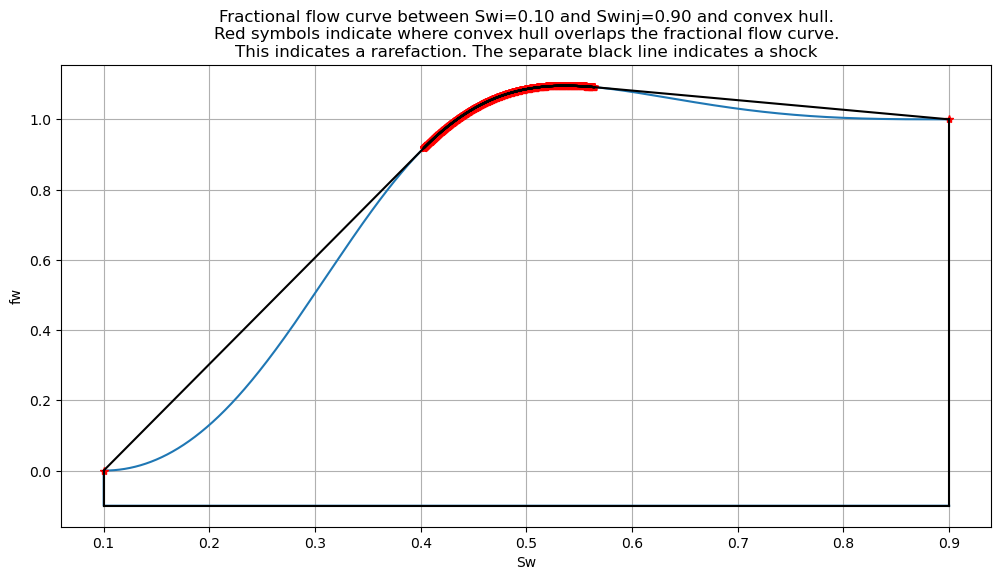

In [14]:
# Set Swinj to 1-Sorw by hand (this is not a recommended practice)
bl_dip_neg.Swinj = 1.0 - bl_dip_neg.Sorw
# Setting the Swi value forces an update of the convex hull calculations. Note that this messes
# up the Welge calculations as those are not able to identify the second shock
bl_dip_neg.set_Swi(bl_dip_neg.Scw)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(bl_dip_neg.box.T[0],bl_dip_neg.box.T[1])
ax.plot(bl_dip_neg.box[bl_dip_neg.vertices,0], bl_dip_neg.box[bl_dip_neg.vertices,1], 'r*', lw=2)
for simplex in bl_dip_neg.hull.simplices:
    ax.plot(bl_dip_neg.box[simplex, 0], bl_dip_neg.box[simplex, 1], 'k-')
ax.set_title(f'Fractional flow curve between Swi={bl_dip_neg.Swi:4.2f} and Swinj={bl_dip_neg.Swinj:4.2f} and convex hull.\n'
          f'Red symbols indicate where convex hull overlaps the fractional flow curve.\n'
          f'This indicates a rarefaction. The separate black line indicates a shock')
ax.set_ylabel('fw')
ax.set_xlabel('Sw')
ax.grid()

Note that the second shock from Swinj to ~0.55 moves backwards.

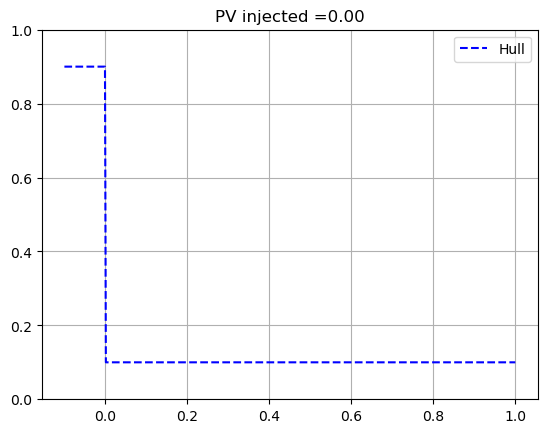

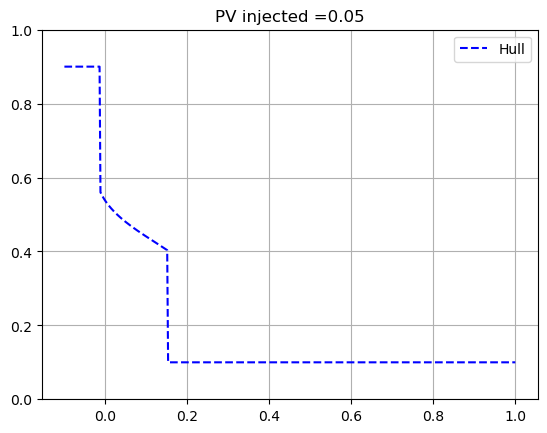

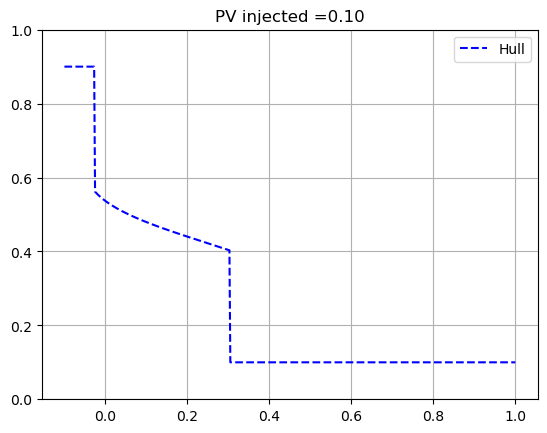

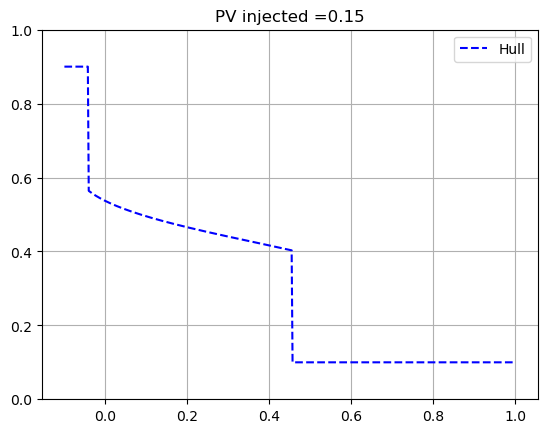

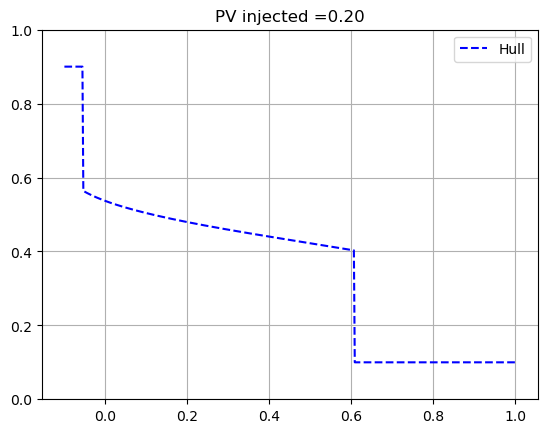

In [15]:
ts = np.linspace(0, 0.2, 5)
xs = np.linspace(-0.1, 1, 501)
for t in ts:
    data_hull = pd.Series()
    for x in xs:
        data_hull[x] =bl_dip_neg.calc_Sol_hull(x,t)
        plt.title(f'PV injected ={t:4.2f}')
    plt.plot(data_hull, 'b--', label='Hull')
    plt.legend()
    plt.ylim(0,1)
    plt.grid()
    plt.show()

# Changing the initial water saturation

By default the Buckley Leverett solution is determined for an initial saturation, Swi, equal to Scw.
The code allows changing the initial water saturation by applying the method 'set_Swi'. This changes the intial water saturation in the BuckleyLeverett instance and updates the internal calculations. 
The initial water saturation needs to be smaller than the injection saturation Swinj

In [16]:
# The viscosities are input in cP.
params = { 'krwe': 1.0, 'nw': 2., 'Scw': 0.1,
           'kroe': 1.0, 'no': 2, 'Sorw': 0.1,
           'muo': 2, 'muw': 1.0}

# The absolute permeability is input in mD.
# The water and oil densities, rhow and rhoo, are input in kg/m^3.
# The total flow rate, qtot, is input in m^3/day.
# The cross-sectional area, area, is input in m^2.
# The dip angle, dip, is input in degrees. It is measured wrt the horizontal plane
# and the positive direction is anti-clockwise
grav_params = {'kabs': 1000, 'kroe': params['kroe'], 'muo': params['muo'],
               'rhow': 1000, 'rhoo': 800, 'qtot': 10, 'area': 1000, 'dip':-20}

# Calculate the dimensionless gravity number, NG
NG = blu.calc_NG(params_dict = grav_params)
print(f'Dimensionless gravity number incl. dip effect = {NG:6.4e}')
print(f'Dimensionless gravity number excl. dip effect = {NG/np.sin(grav_params['dip']*np.pi/180):4.2e}')

# Gravity is included for GravOn=True, otherwise it is not included.
bl_ini = blu.BuckleyLeverett(params_dict = params, GravOn=False, NG=NG)

Dimensionless gravity number incl. dip effect = -2.8609e+00
Dimensionless gravity number excl. dip effect = 8.36e+00
__init__: Swinj = 9.00000000e-01
BL_events: Sw1 = 5.61880215e-01, events = rare + shock


Sw1 = 0.5619
Mobility ratio             = 2.00e+00
Shock front mobility ratio = 8.45e-01
rarefaction speed, front = shock speed = 1.71e+00
Breakthrough after 5.86e-01 PV injected


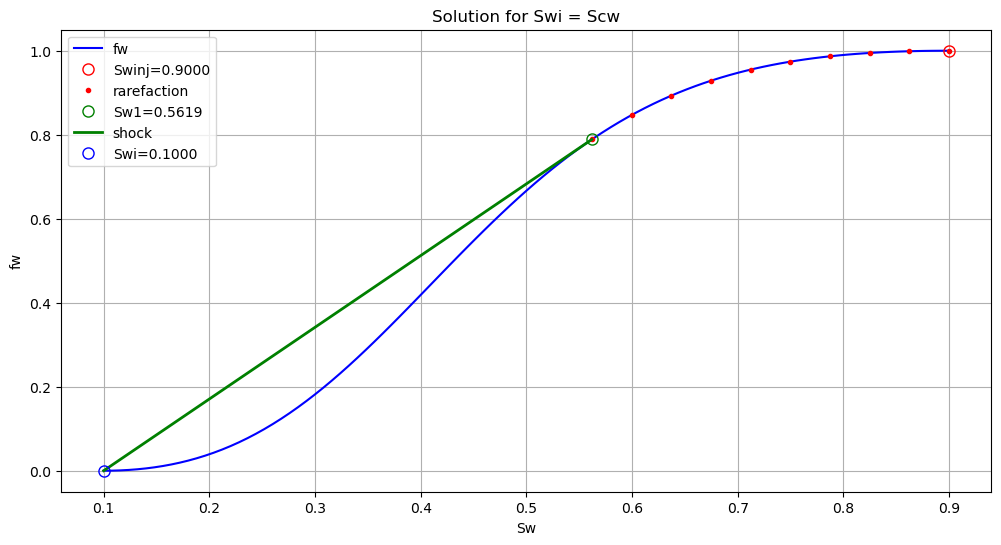

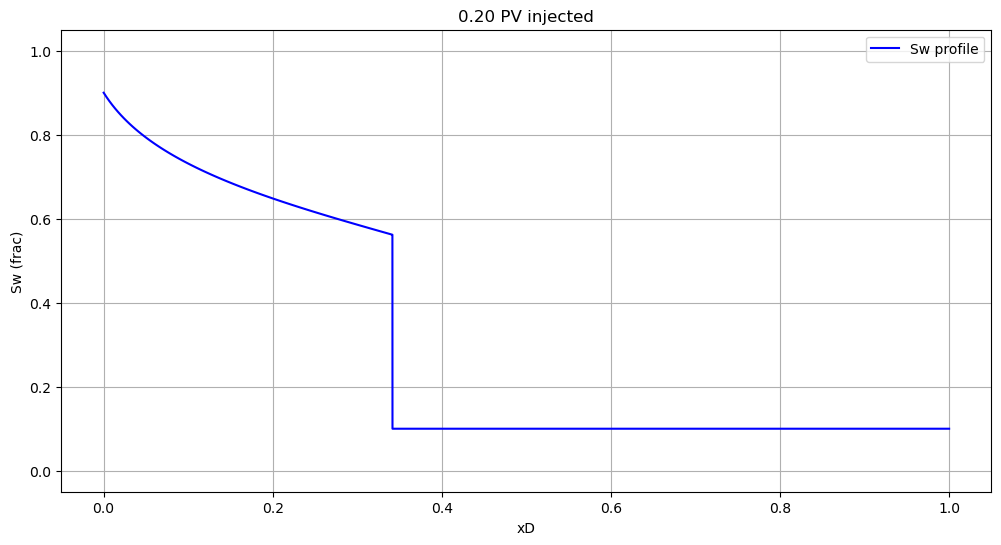

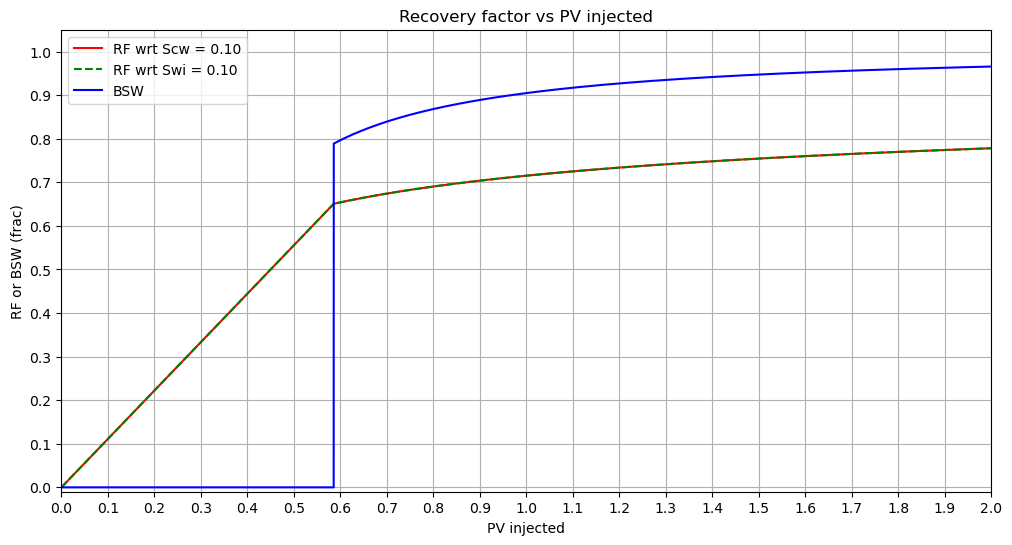

In [17]:
fig, ax = bl_ini.plot_solution()
ax.set_title('Solution for Swi = Scw')
data, fig_prf, ax_prf = bl_ini.plot_profile(0.2,sizex=12, sizey=6) 
RF_Scw, RF_Swi, BSW, fig_RF, ax_RF = bl_ini.plot_RF()
fig_RF.set_figheight(6)
fig_RF.set_figwidth(12)
ax_RF.set_xlim(0,2)
ax_RF.set_xticks(np.arange(0,2.05,0.1)); # This semicolon suppresses output from this command

BL_events: Sw1 = 4.65941686e-01, events = rare + shock
Sw1 = 0.4659
Mobility ratio             = 2.00e+00
Shock front mobility ratio = 1.04e+00
rarefaction speed, front = shock speed = 2.44e+00
Breakthrough after 4.10e-01 PV injected


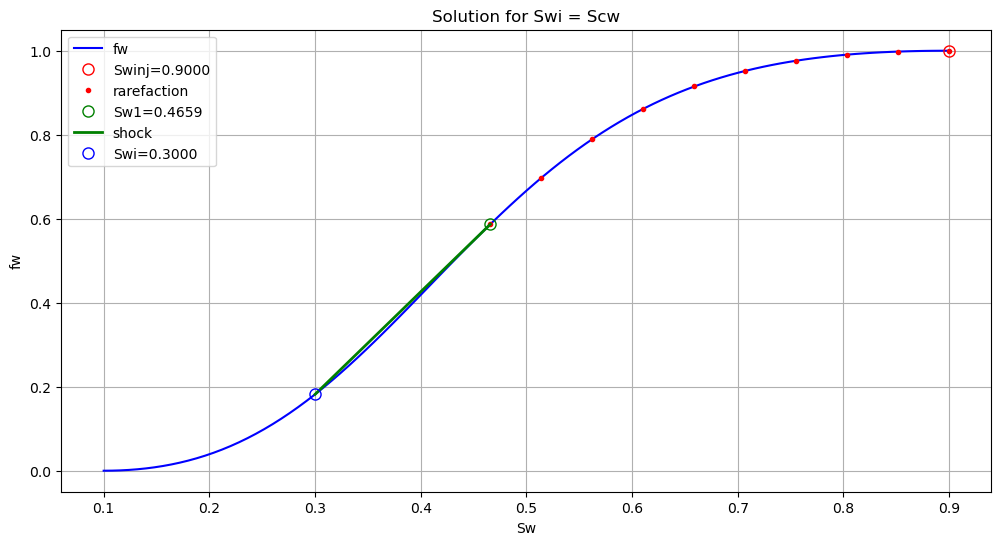

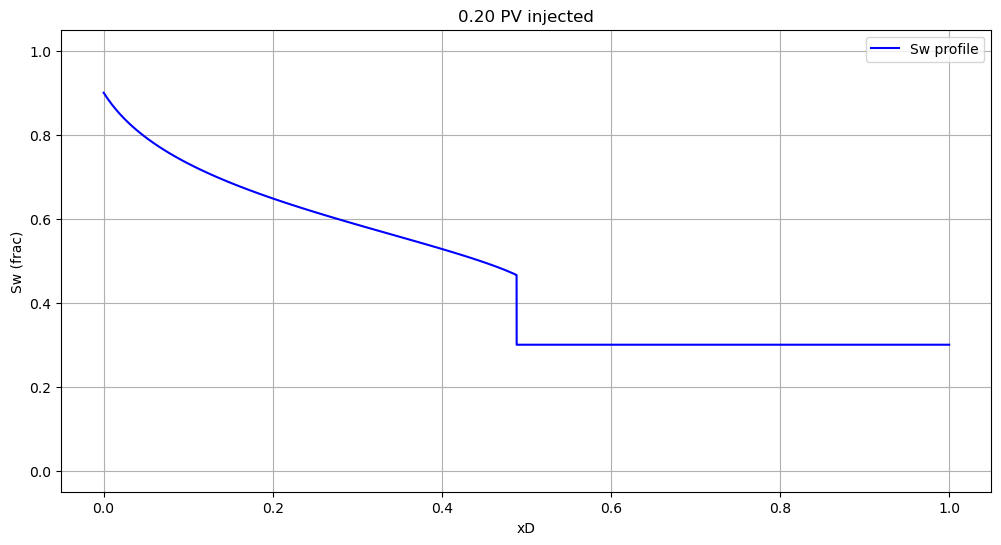

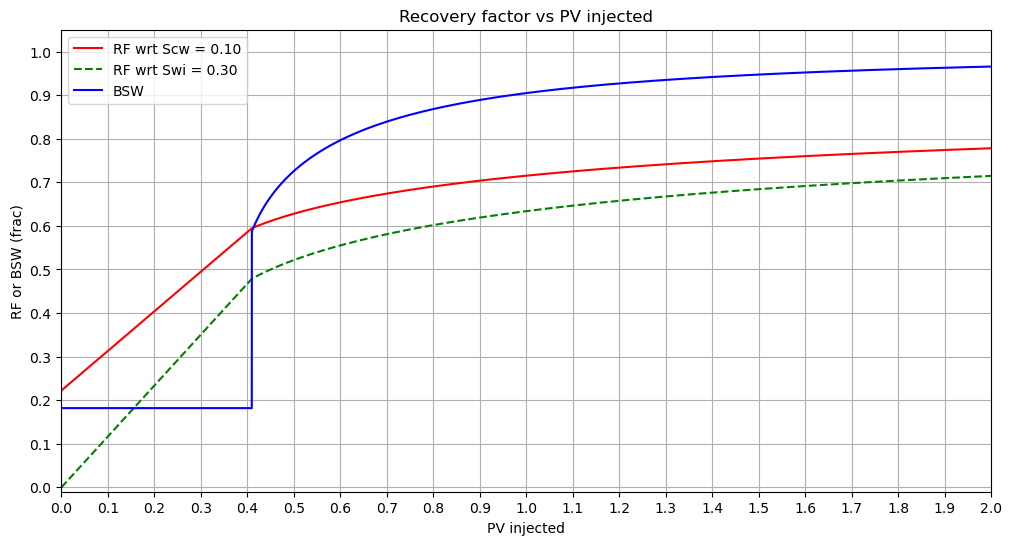

In [18]:
bl_ini.set_Swi(0.3)

fig, ax = bl_ini.plot_solution()
ax.set_title('Solution for Swi = Scw')
data, fig_prf, ax_prf = bl_ini.plot_profile(0.2,sizex=12, sizey=6) 
RF_Scw, RF_Swi, BSW, fig_RF, ax_RF = bl_ini.plot_RF()
fig_RF.set_figheight(6)
fig_RF.set_figwidth(12)
ax_RF.set_xlim(0,2)
ax_RF.set_xticks(np.arange(0,2.05,0.1)); # This semicolon suppresses output from this command

BL_events: Sw1 = 6.00000000e-01, events = rare, Error from brentq:  f(a) and f(b) must have different signs
Mobility ratio = 2.00e+00
rarefaction speed, front = 1.38e+00
Breakthrough after 7.25e-01 PV injected


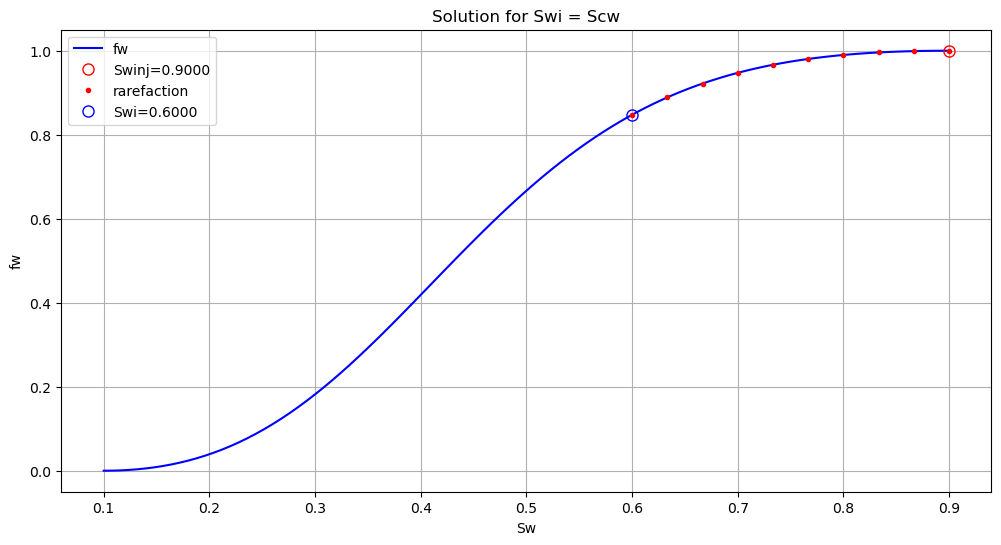

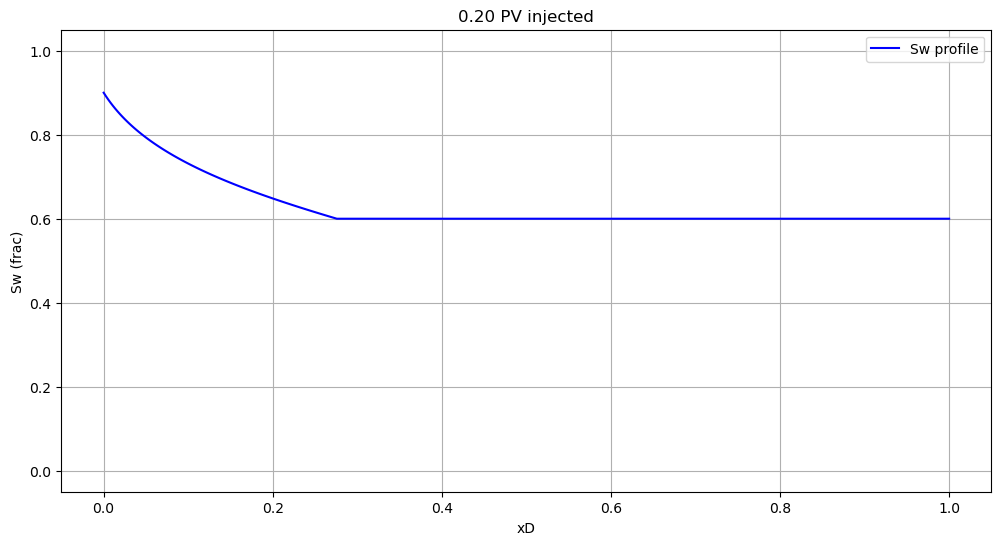

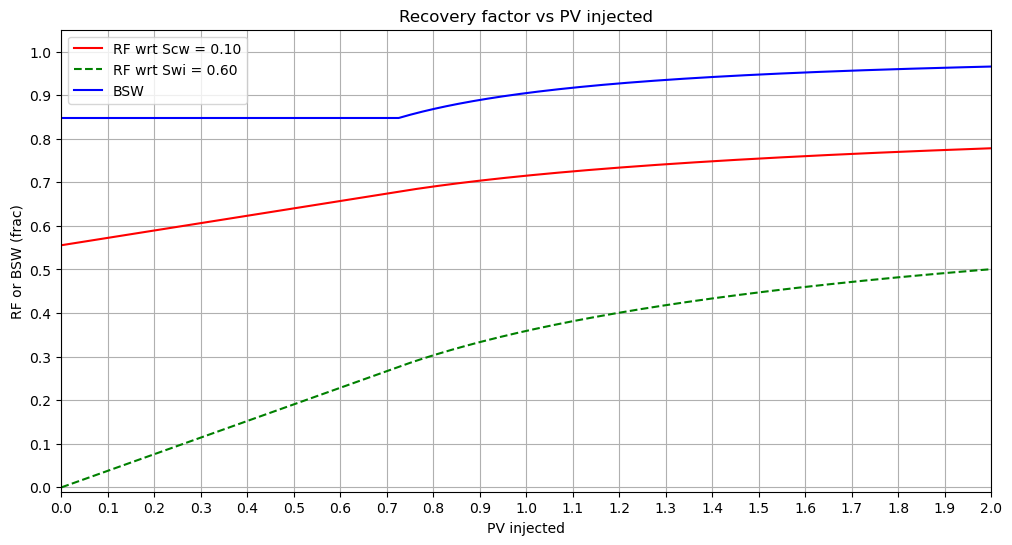

In [19]:
bl_ini.set_Swi(0.6)

fig, ax = bl_ini.plot_solution()
ax.set_title('Solution for Swi = Scw')
data, fig_prf, ax_prf = bl_ini.plot_profile(0.2,sizex=12, sizey=6) 
RF_Scw, RF_Swi, BSW, fig_RF, ax_RF = bl_ini.plot_RF()
fig_RF.set_figheight(6)
fig_RF.set_figwidth(12)
ax_RF.set_xlim(0,2)
ax_RF.set_xticks(np.arange(0,2.05,0.1)); # This semicolon suppresses output from this command

# Average water saturation

Checking the analytical average water saturation calculations against numerical ones.

Dimensionless gravity number incl. dip effect = 1.9073e+00
Dimensionless gravity number excl. dip effect = 5.58e+00
__init__: Swinj = 9.00000000e-01
BL_events: Sw_lo = 2.05186258e-01
BL_events: Sw1 = 5.78424670e-01, events = rare + shock
Sw1 = 0.5784
Mobility ratio             = 3.00e+00
Shock front mobility ratio = 1.14e+00
rarefaction speed, front = shock speed = 1.73e+00
Breakthrough after 5.79e-01 PV injected


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Sw', ylabel='fw'>)

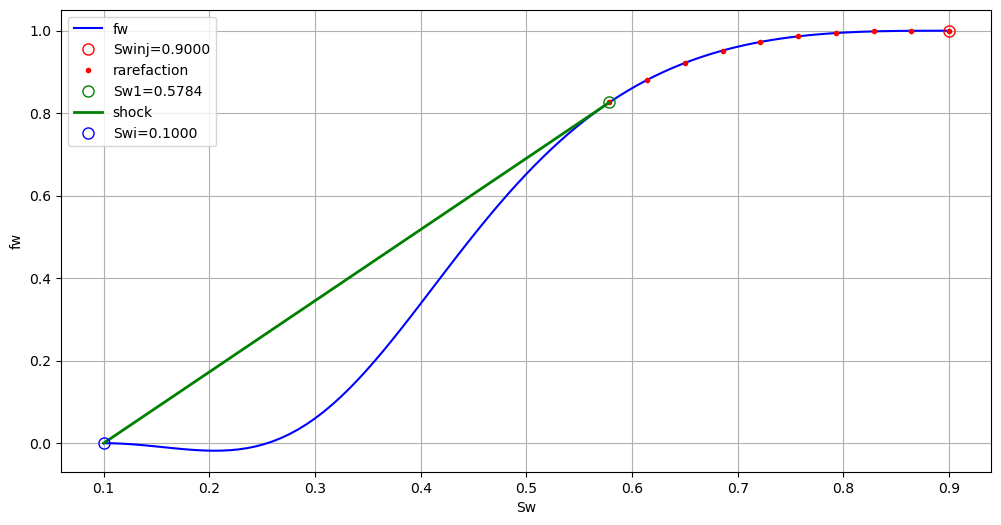

In [20]:
# The viscosities are input in cP.
params = { 'krwe': 1.0, 'nw': 2., 'Scw': 0.1,
           'kroe': 1.0, 'no': 3, 'Sorw': 0.1,
           'muo': 3, 'muw': 1.0}

# The absolute permeability is input in mD.
# The water and oil densities, rhow and rhoo, are input in kg/m^3.
# The total flow rate, qtot, is input in m^3/day.
# The cross-sectional area, area, is input in m^2.
# The dip angle, dip, is input in degrees. It is measured wrt the horizontal plane
# and the positive direction is anti-clockwise
grav_params = {'kabs': 1000, 'kroe': params['kroe'], 'muo': params['muo'],
               'rhow': 1000, 'rhoo': 800, 'qtot': 10, 'area': 1000, 'dip':20}

# Calculate the dimensionless gravity number, NG
NG = blu.calc_NG(params_dict = grav_params)
print(f'Dimensionless gravity number incl. dip effect = {NG:6.4e}')
print(f'Dimensionless gravity number excl. dip effect = {NG/np.sin(grav_params['dip']*np.pi/180):4.2e}')

# Gravity is included for GravOn=True, otherwise it is not included.
bl_sat = blu.BuckleyLeverett(params_dict = params, GravOn=True, NG=NG)

bl_sat.plot_solution()

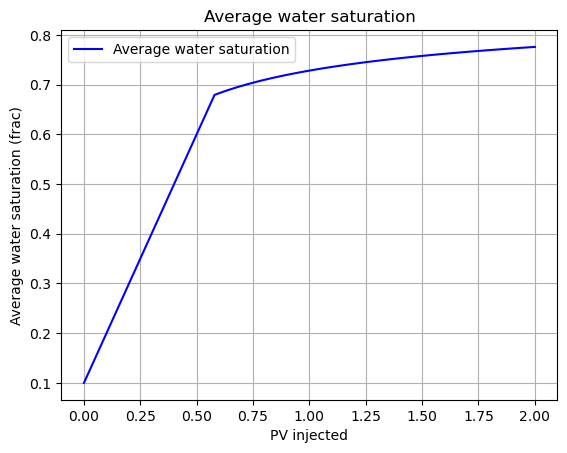

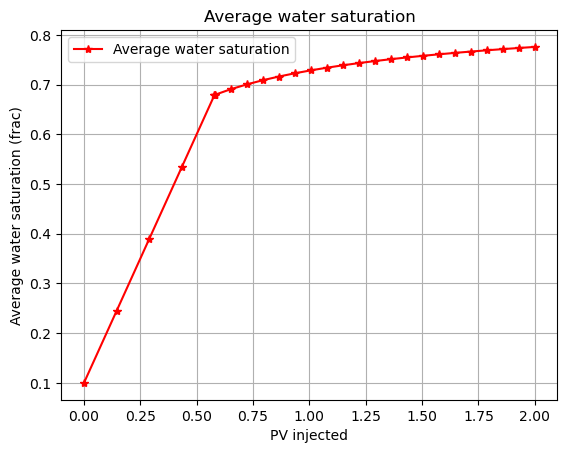

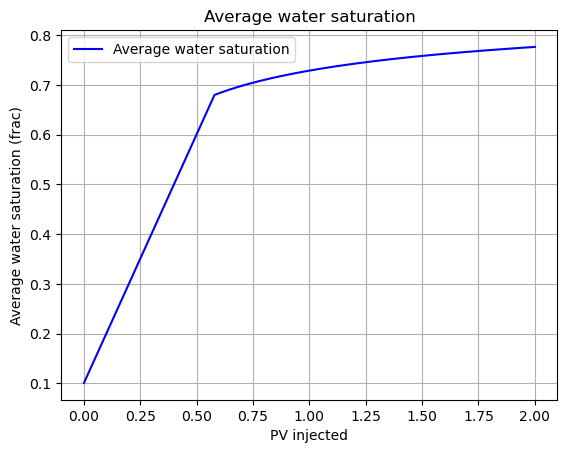

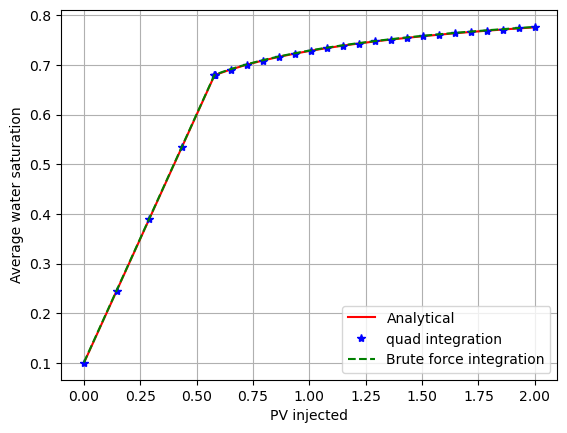

In [21]:
# Analytical calculation
Savg_ana, fig_ana, ax_ana = bl_sat.plot_Savg()
# Integration using SciPy quad routine
Savg_int, fig_int, ax_int = bl_sat.plot_Savg_Integration()
# Brute force integration
Savg_bf,  fig_bf,  ax_bf  = bl_sat.plot_Savg_brute_force()

fig, ax = plt.subplots()
ax.plot(Savg_ana, 'r-', label = 'Analytical')
ax.plot(Savg_int, 'b*', label = 'quad integration')
ax.plot(Savg_bf,  'g--', label = 'Brute force integration')
ax.set_xlabel('PV injected')
ax.set_ylabel('Average water saturation')
ax.legend()
ax.grid()

# Gravity check

In [22]:
# The viscosities are input in cP.
params = { 'krwe': 1.0, 'nw': 2., 'Scw': 0.1,
           'kroe': 1.0, 'no': 3, 'Sorw': 0.1,
           'muo': 5, 'muw': 1.0}

# The absolute permeability is input in mD.
# The water and oil densities, rhow and rhoo, are input in kg/m^3.
# The total flow rate, qtot, is input in m^3/day.
# The cross-sectional area, area, is input in m^2.
# The dip angle, dip, is input in degrees. It is measured wrt the horizontal plane
# and the positive direction is anti-clockwise
grav_params = {'kabs': 1000, 'kroe': params['kroe'], 'muo': params['muo'],
               'rhow': 1000, 'rhoo': 800, 'qtot': 18, 'area': 1000, 'dip':-10}

# Calculate the dimensionless gravity number, NG
NG = blu.calc_NG(params_dict = grav_params)
print(f'Dimensionless gravity number incl. dip effect = {NG:6.4e}')
print(f'Dimensionless gravity number excl. dip effect = {NG/np.sin(grav_params['dip']*np.pi/180):4.2e}')

# Gravity is included for GravOn=True, otherwise it is not included.
bl_chk = blu.BuckleyLeverett(params_dict = params, GravOn=True, NG=NG)

Dimensionless gravity number incl. dip effect = -3.2279e-01
Dimensionless gravity number excl. dip effect = 1.86e+00
__init__: Swinj = 7.29721095e-01
BL_events: Sw1 = 3.78305426e-01, events = rare + shock


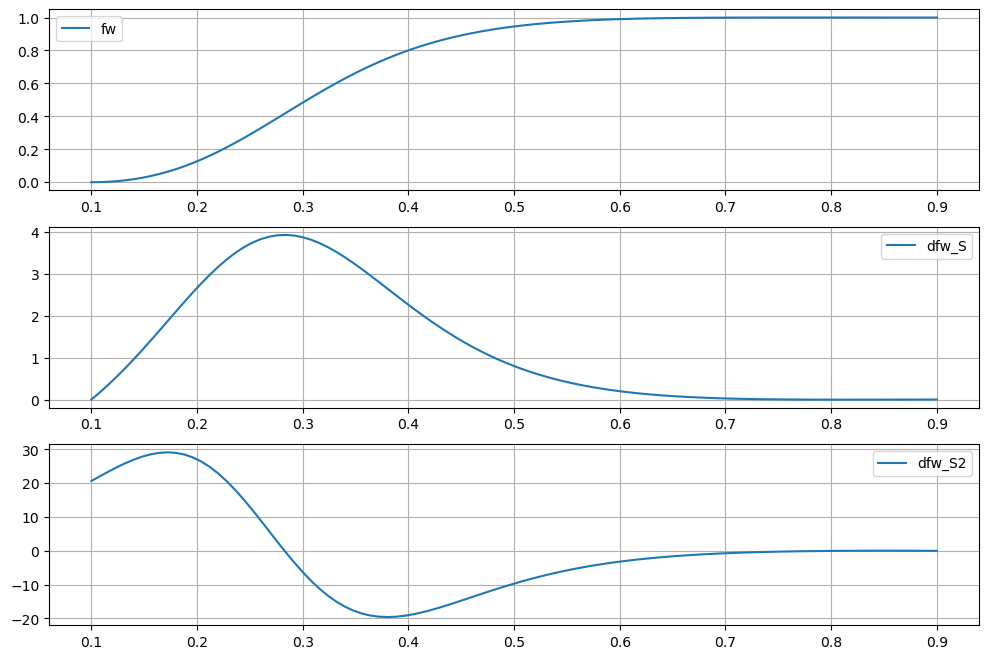

In [23]:
Ss = np.linspace(bl_chk.Scw, 1.0-bl_chk.Sorw, 101)

fig, ax = plt.subplots(3,1, figsize=(12,8))
ax[0].plot(Ss, bl_chk.fw(Ss), label = 'fw')
ax[1].plot(Ss, bl_chk.dfw_S(Ss), label = 'dfw_S')
ax[2].plot(Ss, bl_chk.dfw_S2(Ss), label = 'dfw_S2')
for i in range(3):
    ax[i].grid()
    ax[i].legend()

# Rarefaction from ODE

The rarefaction solution is self-similar, i.e. for a rarefaction wave:
$$
S_w(x,t) = R(\xi=x/t)
$$

In the code the rarefaction solution is found by inverting the equation:
$$
\dfrac{\partial f_w}{\partial S_w}\left( R(\xi) \right) = \xi
$$

The rarefaction wave also satisfies the following ODE:
$$
\dfrac{d}{d \xi}\left(R(\xi)\right) = \left. 1 \middle/ \dfrac{\partial^2 f_w}{\partial S_w^2}\left(R(\xi)\right) \right.

$$

Below we test the equivalence of these solutions

Dimensionless gravity number incl. dip effect = 1.1444e+00
Dimensionless gravity number excl. dip effect = 3.35e+00
__init__: Swinj = 9.00000000e-01
BL_events: Sw_lo = 1.23638293e-01
BL_events: Sw1 = 4.92281068e-01, events = rare + shock
Sw1 = 0.4923
Mobility ratio             = 5.00e+00
Shock front mobility ratio = 1.33e+00
rarefaction speed, front = shock speed = 1.95e+00
Breakthrough after 5.13e-01 PV injected


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Sw', ylabel='fw'>)

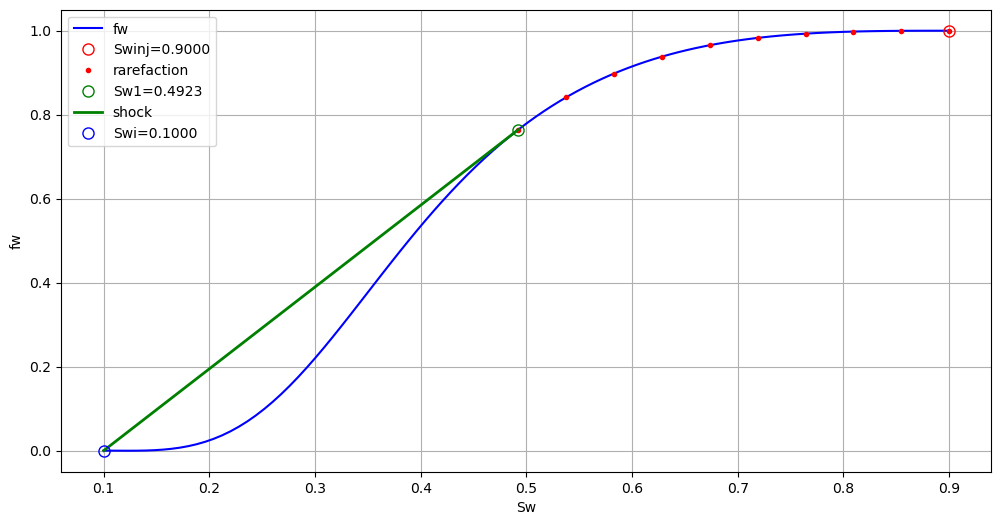

In [24]:
# The viscosities are input in cP.
params = { 'krwe': 1.0, 'nw': 2., 'Scw': 0.1,
           'kroe': 1.0, 'no': 3, 'Sorw': 0.1,
           'muo': 5, 'muw': 1.0}

# The absolute permeability is input in mD.
# The water and oil densities, rhow and rhoo, are input in kg/m^3.
# The total flow rate, qtot, is input in m^3/day.
# The cross-sectional area, area, is input in m^2.
# The dip angle, dip, is input in degrees. It is measured wrt the horizontal plane
# and the positive direction is anti-clockwise
grav_params = {'kabs': 1000, 'kroe': params['kroe'], 'muo': params['muo'],
               'rhow': 1000, 'rhoo': 800, 'qtot': 10, 'area': 1000, 'dip':20}

# Calculate the dimensionless gravity number, NG
NG = blu.calc_NG(params_dict = grav_params)
print(f'Dimensionless gravity number incl. dip effect = {NG:6.4e}')
print(f'Dimensionless gravity number excl. dip effect = {NG/np.sin(grav_params['dip']*np.pi/180):4.2e}')

# Gravity is included for GravOn=True, otherwise it is not included.
bl_Rksi = blu.BuckleyLeverett(params_dict = params, GravOn=True, NG=NG)

bl_Rksi.plot_solution()

In [25]:
# Calculate the boundaries of the rarefaction wave: Sw=1-Sorw and Sw=Sw1
ksi1= bl_Rksi.dfw_S(bl_Rksi.Swinj); ksi2=bl_Rksi.dfw_S(bl_Rksi.Sw1)
ksi1, ksi2

(np.float64(0.0), np.float64(1.9484719033367466))

In [26]:
# Determine the rarefaction using the inversion method described above
ksis = np.linspace(ksi1,ksi2,101)
rare = bl_Rksi.rare_wave(ksis,Sl=1.0-bl_Rksi.Sorw,Sr=bl_Rksi.Sw1)

In [27]:
# Set up the ordinary differential equation for the rarefaction wave (method 2)
# eps is required to avoid numerical issues at the ksi1 boundary (Sw=1-Sorw: the second derivative of fw wrt Sw is zero)
eps = 1e-4
ksis1 = np.linspace(ksi2,ksi1+eps,501)

def ode(x,ksi):
    S = x
    dS_dksi = 1.0/bl_Rksi.dfw_S2(S)
    return dS_dksi

x0 = bl_Rksi.Sw1
Srare = odeint(ode,x0,ksis1,full_output=0)

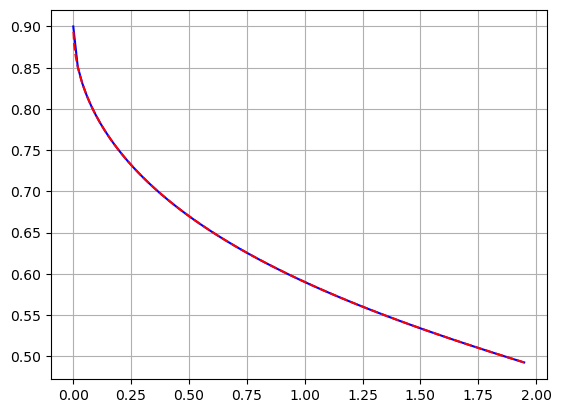

In [28]:
# Compare the two results: they match
plt.plot(ksis,rare, 'b-')
plt.plot(ksis1,Srare.T[0],'r--')
plt.grid()

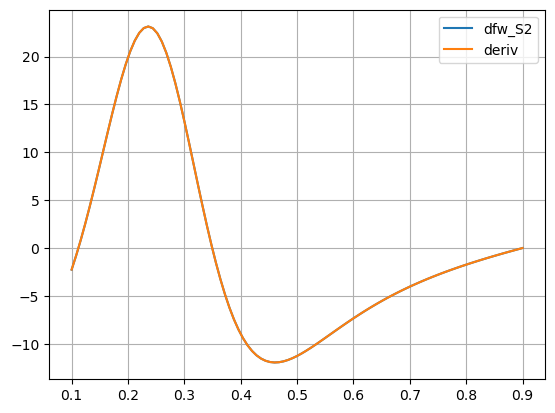

In [29]:
eps = 1e-4
Ss = np.linspace(bl_Rksi.Scw, 1 - bl_Rksi.Sorw, 101)
def deriv(Sw,ff, eps):
    res = (ff.dfw_S(Sw+eps)-ff.dfw_S(Sw))/eps
    return res

plt.plot(Ss, bl_Rksi.dfw_S2(Ss), label='dfw_S2')
plt.plot(Ss, deriv(Ss,bl_Rksi,eps),label='deriv')
plt.legend()
plt.grid()